In [11]:
from pathlib import Path

from decord import VideoReader, cpu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import towhee

In [3]:
res = (
    towhee.glob["path"]("../data/sequences/*.mp4")
    .video_decode.ffmpeg["path", "frames"]()
    .action_classification.movinet["frames", ("labels", "scores", "features")](
        model_name="movineta0"
    )
    .select["path", "labels", "scores", "features"]()
)
res.show(formatter={"path": "video_path"})

objc[31170]: Class AVFFrameReceiver is implemented in both /usr/local/Cellar/ffmpeg/5.1/lib/libavdevice.59.7.100.dylib (0x11119a378) and /Users/schaller/development/unifr/master/0_datasets/ilids/.venv/lib/python3.10/site-packages/av/.dylibs/libavdevice.58.13.100.dylib (0x12b66ef98). One of the two will be used. Which one is undefined.
objc[31170]: Class AVFAudioReceiver is implemented in both /usr/local/Cellar/ffmpeg/5.1/lib/libavdevice.59.7.100.dylib (0x11119a3c8) and /Users/schaller/development/unifr/master/0_datasets/ilids/.venv/lib/python3.10/site-packages/av/.dylibs/libavdevice.58.13.100.dylib (0x12b66efe8). One of the two will be used. Which one is undefined.


path,labels,scores,features
,shaking hands playing didgeridoo stretching arm playing recorder finger snapping,"[1.0,0.0,0.0,0.0,...] len=5","[-8.716055e-05, 0.32585073, -6.107876e-10, ...] shape=(480,)"
,golf putting mowing lawn passing soccer ball shooting goal (soccer) golf chipping,"[0.26279,0.13107,0.07597,0.07325,...] len=5","[-0.033395447, -0.057963792, 0.018810105, ...] shape=(480,)"
,using a paint roller cleaning windows golf chipping mopping floor stretching arm,"[0.20276,0.12726,0.09869,0.07399,...] len=5","[0.003324972, -0.08298002, 0.009345626, ...] shape=(480,)"
,stretching arm stretching leg mountain climber (exercise) golf putting marching,"[0.3271,0.09244,0.05875,0.04745,...] len=5","[-0.0017709506, -0.027157899, -0.0048236535, ...] shape=(480,)"
,golf putting golf chipping shooting goal (soccer) passing soccer ball golf driving,"[0.50177,0.07082,0.03776,0.03005,...] len=5","[-0.009889067, -0.015271472, -0.006642203, ...] shape=(480,)"


In [4]:
ALL_MOVINET_MODELS = [
    "movineta0",
    "movineta1",
    "movineta2",
    "movineta3",
    "movineta4",
    "movineta5",
]

In [5]:
all_movinets = [
    towhee.glob["path"]("../data/sequences/*.mp4")
    .video_decode.ffmpeg["path", "frames"]()
    .action_classification.movinet["frames", ("labels", "scores", "features")](
        model_name="movineta0"
    )
    .select["path", "labels", "scores"]()
    for model_name in ALL_MOVINET_MODELS
]

In [6]:
df = pd.DataFrame(
    [
        dict(
            model=movinet_model,
            path=classification.path,
            label=label,
            score=classification.scores[i],
        )
        for movinet_model, res in zip(ALL_MOVINET_MODELS, all_movinets)
        for classification in res.to_list()
        for i, label in enumerate(classification.labels)
    ]
)
df

,model,path,label,score
0,movineta0,../data/sequences/SZTR_video_SZTRA201a09_00_00...,shaking hands,1.00000
1,movineta0,../data/sequences/SZTR_video_SZTRA201a09_00_00...,playing didgeridoo,0.00000
2,movineta0,../data/sequences/SZTR_video_SZTRA201a09_00_00...,stretching arm,0.00000
3,movineta0,../data/sequences/SZTR_video_SZTRA201a09_00_00...,playing recorder,0.00000
4,movineta0,../data/sequences/SZTR_video_SZTRA201a09_00_00...,finger snapping,0.00000
...,...,...,...,...
295,movineta5,../data/sequences/SZTR_video_SZTRA203b17_00_00...,bowling,0.36860
296,movineta5,../data/sequences/SZTR_video_SZTRA203b17_00_00...,using a paint roller,0.03735
297,movineta5,../data/sequences/SZTR_video_SZTRA203b17_00_00...,cutting apple,0.02618
298,movineta5,../data/sequences/SZTR_video_SZTRA203b17_00_00...,playing dominoes,0.02583


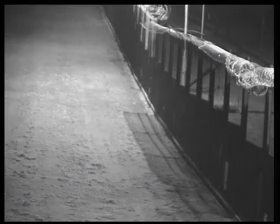

In [14]:
def get_middle_frame(frame: Path):
    vr = VideoReader(str(frame), ctx=cpu(0))
    middle_frame_idx = int(len(vr) / 2)

    frame = vr[middle_frame_idx]

    return Image.fromarray(frame.asnumpy())


# get_middle_frame(Path(df.iloc[0]["path"]))

In [7]:
videos = df["path"].unique()

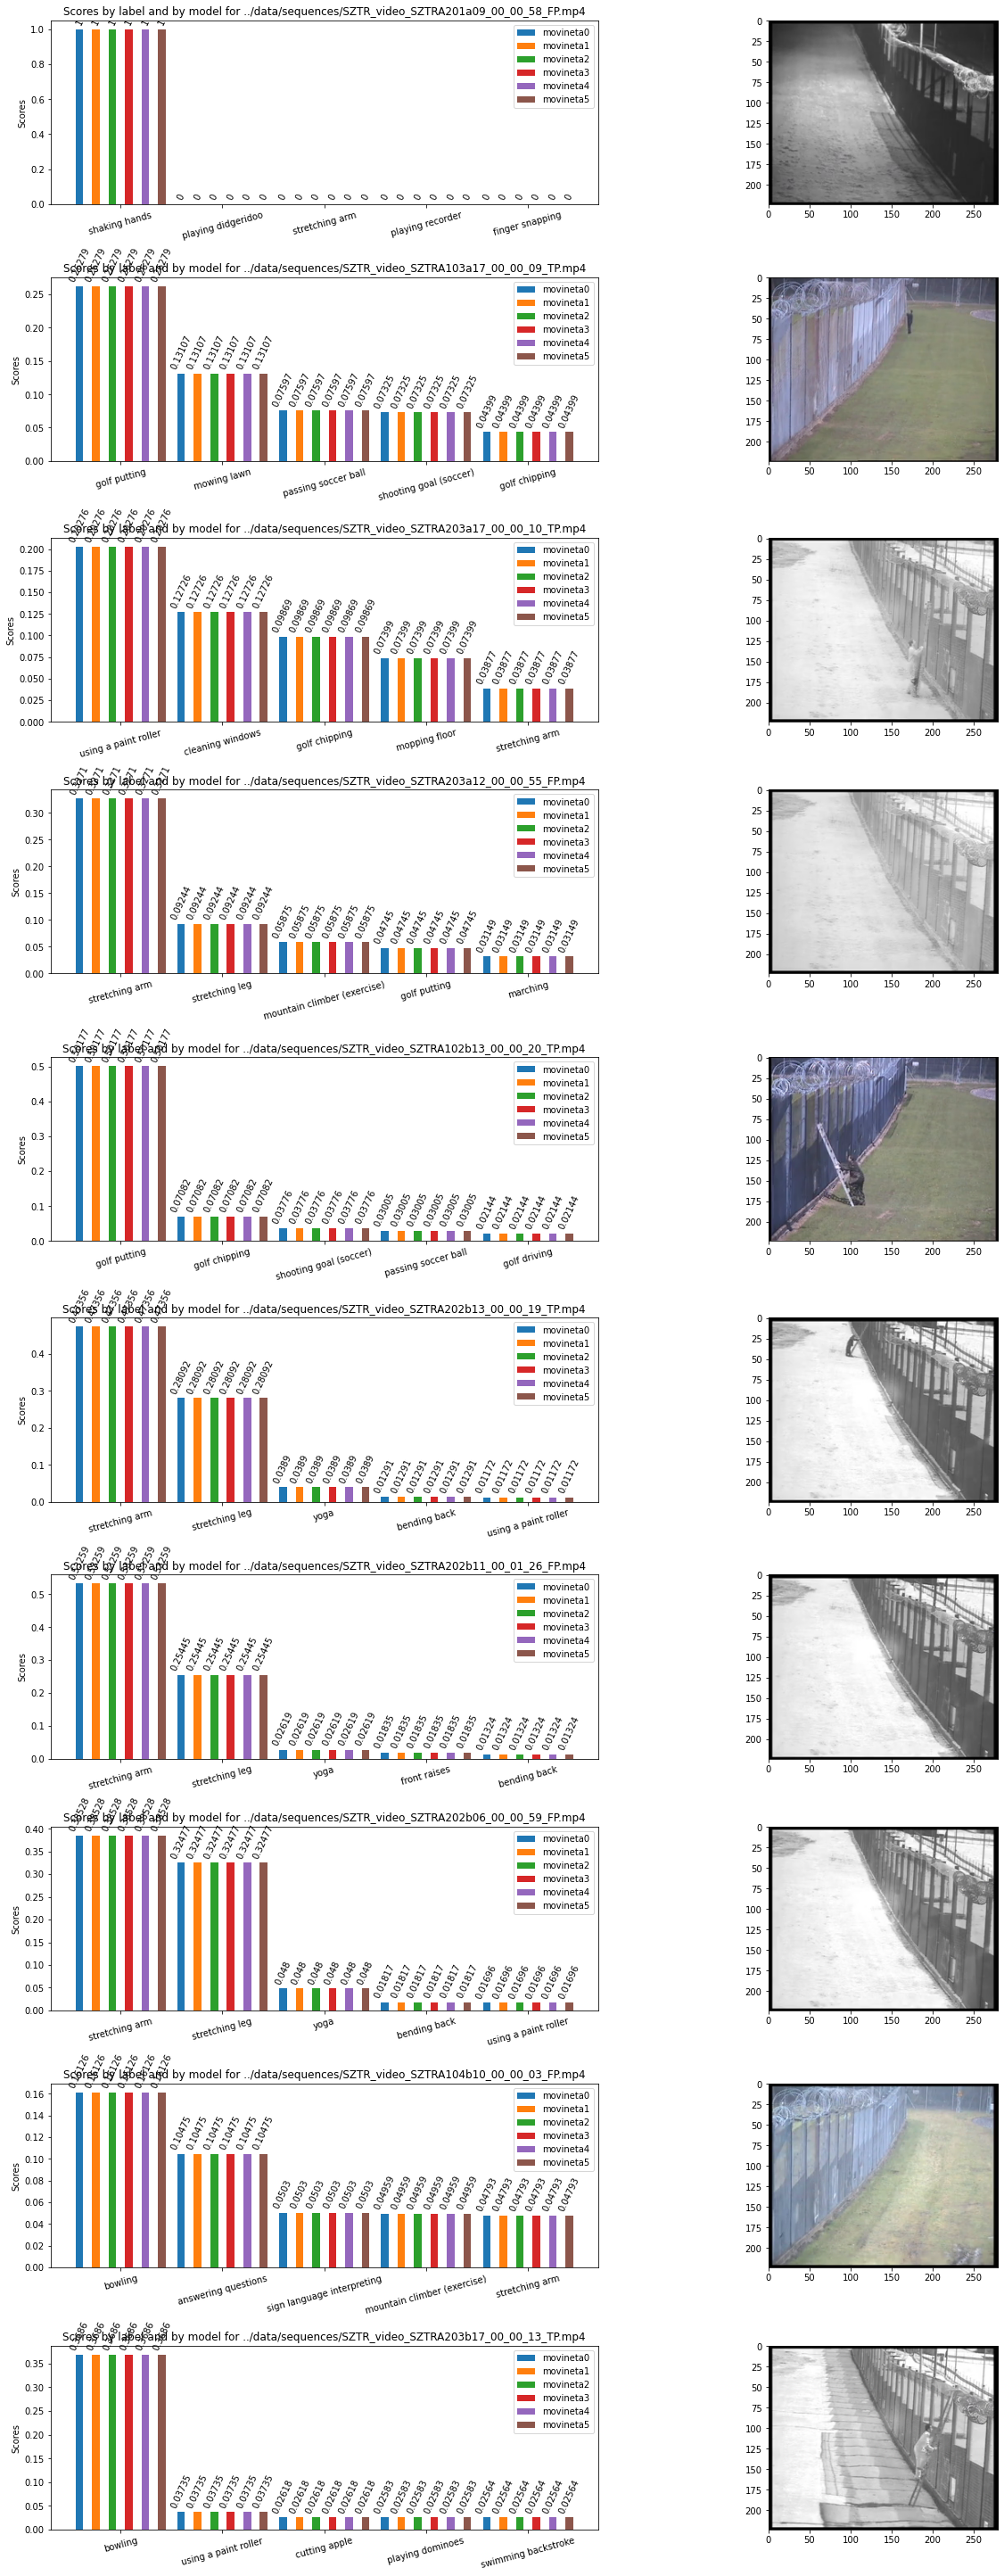

In [17]:
def plot_score_by_label_model(df: pd.DataFrame, ax, title_prefix: str):
    BAR_WIDTH = 0.15

    labels = df["label"].unique()

    X = np.arange(len(labels)) * 2
    X_shift = np.linspace(
        0, len(ALL_MOVINET_MODELS) * (BAR_WIDTH * 1.8), len(ALL_MOVINET_MODELS)
    )
    X_shift = X_shift - X_shift.mean()

    for i, model in enumerate(ALL_MOVINET_MODELS):
        values = df[df["model"] == model]["score"]

        # print(X + X_shift[i], title_prefix, model)

        rects = ax.bar(X + X_shift[i], values, BAR_WIDTH, label=model)
        ax.bar_label(rects, padding=3, rotation=65)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("Scores")
    ax.set_title(f"Scores by label and by model for {title_prefix}")
    ax.set_xticks(X, labels, rotation=15)
    ax.legend()


fig, axs = plt.subplots(
    len(videos), 2, figsize=(18, len(videos) * 4), constrained_layout=True
)
for ax_row, video in zip(axs, videos):
    plot_score_by_label_model(df[df["path"] == video], ax_row[0], video)
    ax_row[1].imshow(get_middle_frame(Path(video)))

# fig.tight_layout()

plt.show()